# Домашняя работа
### Тема: Поиск выбросов и генерация новых признаков

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, ShuffleSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Заполняем nan-значения, занчениями NA**

In [3]:
data = data.fillna('NA')

In [4]:
data.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Создаем категириальные данные SalePrice**

In [5]:
quant = []
qunt_list = [0.25, 0.5, 0.75]

for i in qunt_list:
    quant.append(int(np.quantile(data.SalePrice, i)))
print(f'Квантиль: {quant}')

Квантиль: [129975, 163000, 214000]


In [6]:
sp_clf025 = data.loc[data['SalePrice'] <= quant[0], ['SalePrice']].index
sp_clf025_05 = data.loc[(data['SalePrice'] > quant[0]) & (data['SalePrice'] <= quant[1]), ['SalePrice']].index
sp_clf05_075 = data.loc[(data['SalePrice'] > quant[1]) & (data['SalePrice'] < quant[2]), ['SalePrice']].index
sp_clf075 = data.loc[data['SalePrice'] >= quant[2], ['SalePrice']].index

data['SalePrice_cls'] = None
data['SalePrice_cls'][sp_clf025] = 'SalePrice < 0.25q'
data['SalePrice_cls'][sp_clf025_05] = 'SalePrice in range (0.25, 0.5)q'
data['SalePrice_cls'][sp_clf05_075] = 'SalePrice in range (0.5, 0.75)q'
data['SalePrice_cls'][sp_clf075] = 'SalePrice in range > 0.75q'

data['SalePrice_cls'].unique()

C:\Users\Philipp_Rodchenkov\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Philipp_Rodchenkov\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Philipp_Rodchenkov\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Philipp_Ro

array(['SalePrice in range (0.5, 0.75)q', 'SalePrice in range > 0.75q',
       'SalePrice in range (0.25, 0.5)q', 'SalePrice < 0.25q'],
      dtype=object)

In [7]:
data['SalePrice_cls'].describe()

count                                1460
unique                                  4
top       SalePrice in range (0.25, 0.5)q
freq                                  367
Name: SalePrice_cls, dtype: object

**Создаем список категориалных данных, удаляем данные float**

In [8]:
cat_list = list(data.dtypes[data.dtypes == object].index)
float_list = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

for i in float_list:
    cat_list.remove(i)

**Заполняем медианными значениями**

In [9]:
med = data.loc[data['LotFrontage'] != 'NA'].median().LotFrontage
data.loc[data['LotFrontage'] == 'NA', ['LotFrontage']] = med
data['LotFrontage'] = data['LotFrontage'].astype(int)

med = data.loc[data['MasVnrArea'] != 'NA'].median().MasVnrArea
data.loc[data['MasVnrArea'] == 'NA', ['MasVnrArea']] = med
data['MasVnrArea'] = data['MasVnrArea'].astype(int)

med = int(data.loc[data['GarageYrBlt'] != 'NA'].median().GarageYrBlt)
data.loc[data['GarageYrBlt'] == 'NA', ['GarageYrBlt']] = med
data['GarageYrBlt'] = data['GarageYrBlt'].astype(int)

**Удаляем всё, где уникальные значения больше 10**

In [10]:
cat_nunique = data[cat_list].nunique()
cat_feat10 = list(cat_nunique[cat_nunique > 10].index)

data[cat_feat10].head()

,Neighborhood,Exterior1st,Exterior2nd
0,CollgCr,VinylSd,VinylSd
1,Veenker,MetalSd,MetalSd
2,CollgCr,VinylSd,VinylSd
3,Crawfor,Wd Sdng,Wd Shng
4,NoRidge,VinylSd,VinylSd


**Делим на данные и таргет**

In [11]:
drop_list = cat_feat10 + ['Id', 'SalePrice']

X = data.drop(drop_list, axis = 'columns')
Y = data['SalePrice_cls']

X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice_cls
0,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,"SalePrice in range (0.5, 0.75)q"
1,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,"SalePrice in range (0.5, 0.75)q"
2,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,SalePrice in range > 0.75q
3,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,"SalePrice in range (0.25, 0.5)q"
4,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,SalePrice in range > 0.75q


**Случайный лес, вывод важности признаков**

In [12]:
le_X = LabelEncoder()
le_Y = LabelEncoder()

X_clf = data[cat_list]
X_clf.drop(columns = ['SalePrice_cls'], axis = 1, inplace = True)

for i in X_clf:
    X_clf[i] = le_X.fit_transform(X_clf[i])


Y_clf = le_Y.fit_transform(Y)

C:\Users\Philipp_Rodchenkov\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Philipp_Rodchenkov\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
X_clf.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,0,6,2,...,5,3,5,5,2,3,4,1,8,0
4,3,1,1,0,3,0,2,0,15,2,...,1,2,5,5,2,3,4,1,8,4


**Случайный лес**

In [14]:
clf_rf = RandomForestClassifier(random_state = 700, n_jobs = -1)

In [15]:
kf = KFold(n_splits = 10, random_state= 500)
kf.get_n_splits(X_clf)

for train_index, test_index in kf.split(X_clf):
    X_train_clf = X_clf.iloc[train_index]
    X_test_clf = X_clf.iloc[test_index]
    y_train_clf = Y_clf[train_index]
    y_test_clf = Y_clf[test_index]

C:\Users\Philipp_Rodchenkov\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [16]:
scores = []

cv = KFold(n_splits = 10, random_state = 100, shuffle = True)

for train_index, test_index in cv.split(X_clf):
    X_train_clf = X_clf.iloc[train_index]
    X_test_clf = X_clf.iloc[test_index]
    y_train_clf = Y_clf[train_index]
    y_test_clf = Y_clf[test_index]
    
    clf_rf.fit(X_train_clf, y_train_clf)
    scores.append(clf_rf.score(X_test_clf, y_test_clf))
scores

[0.7123287671232876,
 0.7054794520547946,
 0.6438356164383562,
 0.636986301369863,
 0.6575342465753424,
 0.6301369863013698,
 0.6986301369863014,
 0.7054794520547946,
 0.6301369863013698,
 0.6917808219178082]

In [17]:
importances = clf_rf.feature_importances_

**Важность признаков**

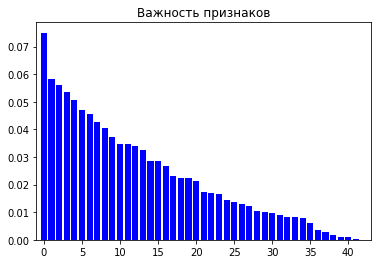

In [18]:
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title('Важность признаков')
plt.bar(range(X_clf.shape[1]), importances[indices], color="b", align="center")
plt.xlim([-1, X_clf.shape[1]])
plt.show()

In [19]:
print('Важность признаков')
for i in range(len(X_clf.columns)):
    print(X_clf.columns[i], ':', importances[i])

Важность признаков
MSZoning : 0.028389060417898876
Street : 0.00026565298307949195
Alley : 0.010521870365740085
LotShape : 0.02250453187050359
LandContour : 0.01210102041749328
Utilities : 0.0
LotConfig : 0.02329139419554991
LandSlope : 0.006255868248131431
Neighborhood : 0.07502215217477122
Condition1 : 0.01697945341354072
Condition2 : 0.0011901422709846004
BldgType : 0.02682428860425656
HouseStyle : 0.04040392284204035
RoofStyle : 0.021297160601482883
RoofMatl : 0.002976622744110623
Exterior1st : 0.03407470837062258
Exterior2nd : 0.03739270856887301
MasVnrType : 0.034616998744953435
ExterQual : 0.05070327552174396
ExterCond : 0.012966606366276555
Foundation : 0.03460568124556017
BsmtQual : 0.05345695513146311
BsmtCond : 0.00981818723408166
BsmtExposure : 0.028578982035420152
BsmtFinType1 : 0.04259989985166196
BsmtFinType2 : 0.016671926894859187
Heating : 0.0015605900671843988
HeatingQC : 0.03254955408676904
CentralAir : 0.007762288409258088
Electrical : 0.008278598452763146
KitchenQu

In [20]:
n_samples = 10
cv = ShuffleSplit(n_splits= n_samples, test_size=0.2, random_state=0)
cross_val_score(clf_rf, X_clf, Y_clf, cv = cv, n_jobs = -1)

array([0.67465753, 0.68150685, 0.69178082, 0.67123288, 0.69520548,
       0.69520548, 0.68493151, 0.67808219, 0.69178082, 0.65753425])

### Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

**Логистическая регрессия**

In [21]:
num_list = [f for f in data if f not in (cat_list)]
num_list.remove('Id')
num_list.remove('SalePrice')

In [22]:
X_lin = data[num_list]
Y_lin = data['SalePrice']
X_lin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MSSubClass     1460 non-null   int64
 1   LotFrontage    1460 non-null   int32
 2   LotArea        1460 non-null   int64
 3   OverallQual    1460 non-null   int64
 4   OverallCond    1460 non-null   int64
 5   YearBuilt      1460 non-null   int64
 6   YearRemodAdd   1460 non-null   int64
 7   MasVnrArea     1460 non-null   int32
 8   BsmtFinSF1     1460 non-null   int64
 9   BsmtFinSF2     1460 non-null   int64
 10  BsmtUnfSF      1460 non-null   int64
 11  TotalBsmtSF    1460 non-null   int64
 12  1stFlrSF       1460 non-null   int64
 13  2ndFlrSF       1460 non-null   int64
 14  LowQualFinSF   1460 non-null   int64
 15  GrLivArea      1460 non-null   int64
 16  BsmtFullBath   1460 non-null   int64
 17  BsmtHalfBath   1460 non-null   int64
 18  FullBath       1460 non-null   int64
 19  HalfBa

In [23]:
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, Y_lin, test_size = 0.2, random_state = 10)

In [24]:
scaler = StandardScaler()
scaler.fit(X_train_lin[num_list])

X_train_lin = scaler.transform(X_train_lin[num_list])
X_test_lin = scaler.transform(X_test_lin[num_list])

**Линейная регрессия**

In [25]:
reg_lr = reg = LinearRegression(n_jobs = -1)

reg_lr.fit(X_train_lin, y_train_lin)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [26]:
print(f'Train: {reg_lr.score(X_train_lin, y_train_lin)}')
print(f'Test: {reg_lr.score(X_test_lin, y_test_lin)}')

Train: 0.8069286492428919
Test: 0.8283875277855778


**Кросс-Валидация**

In [27]:
scores_reg_lin = []

cv = KFold(n_splits = 10, random_state = 100, shuffle = True)

for train_index, test_index in cv.split(X_lin):
    
    X_train_lin = X_lin.iloc[train_index]
    X_test_lin = X_lin.iloc[test_index]
    y_train_lin = Y_lin.iloc[train_index]
    y_test_lin = Y_lin.iloc[test_index]
    
    
    reg_lr.fit(X_train_lin, y_train_lin)

    y_pred_lin_test = reg_lr.predict(X_test_lin)
        
    scores_reg_lin.append(reg_lr.score(X_test_lin, y_test_lin))
print(scores_reg_lin)
print(sum(scores_reg_lin)/len(scores_reg_lin))

[0.8513120970444165, 0.8339413255516415, 0.7776170303361362, 0.8541116621620637, 0.862113817206987, 0.4752975854291459, 0.8729020776732634, 0.645445632028685, 0.8290924033036096, 0.8400634171071721]
0.784189704784312


**Cтекинг**

In [28]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test_clf, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train[train_ind])
        
        meta_train[test_ind] = clf.predict_proba(X_train.iloc[test_ind])[:, 1]
        
        meta_test += clf.predict_proba(X_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits

In [29]:
clf_lr = LogisticRegression(penalty='l2', C=0.1, n_jobs = -1)
clf_lr.fit(X_train_clf, y_train_clf)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
stack_cv = StratifiedKFold(n_splits=10, random_state=600)

meta_train = []
meta_test = []
col_names = []

meta_tr, meta_te = get_meta_features(clf_lr, X_train_clf, y_train_clf, X_test_clf, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

meta_tr, meta_te = get_meta_features(clf_rf, X_train_clf, y_train_clf, X_test_clf, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

C:\Users\Philipp_Rodchenkov\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [31]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [32]:
clf_lr_meta = LogisticRegression(penalty='l2', C=1)
clf_lr_meta.fit(X_meta_train, y_train_clf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
clf_lr_meta.score(X_meta_test, y_test_clf)

0.5753424657534246